In [1]:
# including the project directory to the notebook level
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from tqdm import tqdm
import parse
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    import tensorflow as tf
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp
from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [3]:
# read the pickled file for ahu data
ahudata = dp.readfile('../data/processed/ahu1energy.pkl')

# return pickled df
ahu = ahudata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
ghidata = dp.readfile('../data/processed/ghi.pkl')

# return pickled df
ghi = ghidata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
flowdata = dp.readfile('../data/processed/flow.pkl')

# return pickled df
flow = flowdata.return_df(processmethods=['file2df'])
flow.columns = ['flow']

In [4]:
# selecting only required columns and rearranging them
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'WeatherDataProfile humidity',
    'AHU_1 supplyAirTemp', 'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

# renaming columns
ahu.columns = ['oat', 'orh', 'sat', 'hwe', 'cwe']

# Total energy is sum of heating and coling
ahu['totale'] = ahu['hwe'] + ahu['cwe']
# dropping heating and cooling energy columns
# ahu = ahu.drop(columns=['hwe', 'cwe'])

In [ ]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/smoothbuildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [5]:
# merging ahu and ghi data
df = dp.merge_df_columns([ahu, ghi, flow])

# rearranging columns
#df = df[['oat', 'orh', 'sat', 'Ghi', 'flow', 'totale']]

In [6]:
df.head()

,oat,orh,sat,hwe,cwe,totale,Ghi,flow
2018-07-12 13:55:00,89.554909,76.0,75.443275,0.0,35.590466,35.590466,872.0,43.108143
2018-07-12 14:00:00,89.863190,76.0,75.443275,0.0,33.027813,33.027813,866.0,45.760704
2018-07-12 14:05:00,89.863190,76.0,75.443275,0.0,31.769627,31.769627,859.0,45.840881
2018-07-12 14:10:00,90.484146,69.0,75.443275,0.0,34.195641,34.195641,848.0,43.372566
2018-07-12 14:15:00,90.826981,69.0,75.443275,0.0,31.082222,31.082222,836.0,38.218956


In [7]:
# smooth the hwe and cwe
df_smoothed = dp.dfsmoothing(
    df,
    column_names=list(df.columns),
    Wn=0.08  # 0.15
)

Finished 'dataframeplot' in 0.1099 secs


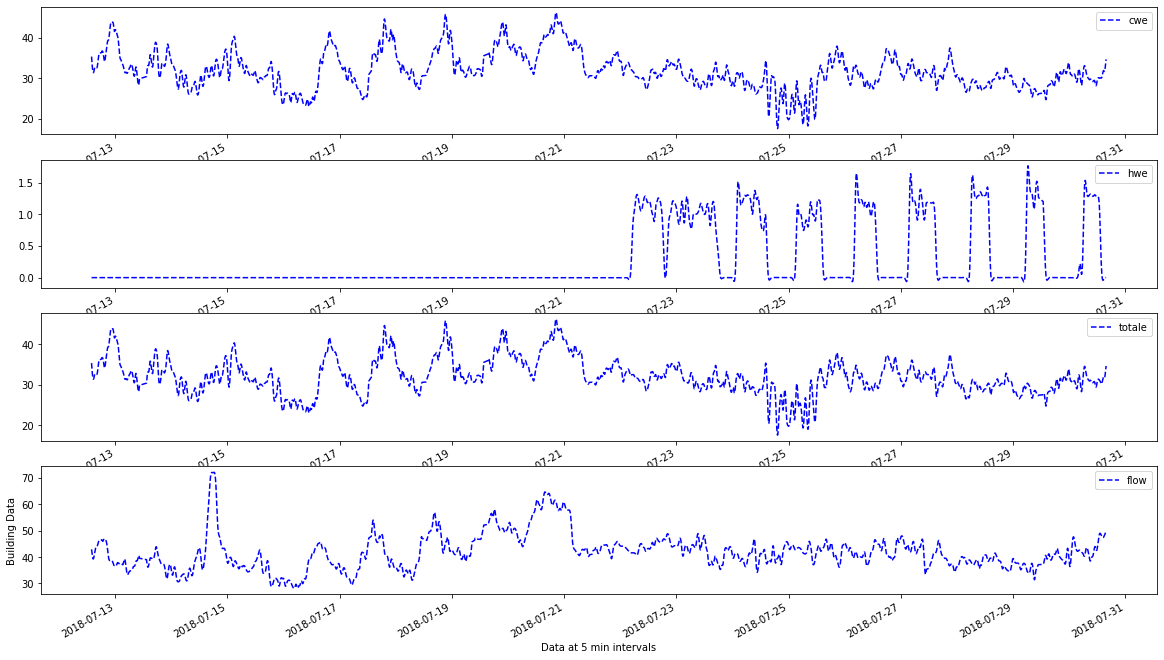

In [8]:
dp.dataframeplot(df=df_smoothed.loc[df_smoothed.index[0:5000],['cwe','hwe','totale','flow']],
                 style='-',
                 xlabel='Data at 5 min intervals',
                 ylabel='Building Data',
                 legend=True,
                 lazy=False)

In [8]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(df_smoothed, subsequence=True, period=1, days=7, hours=0)

In [9]:
len(dflist)

10

In [ ]:
# dflist = [df]

In [10]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat','orh', 'sat', 'Ghi', 'flow'],
        outputcols=['cwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

In [11]:
weeklist[0].keys()
for key,value in weeklist[0].items():
    print("name: {}, value: {}".format(key, value.shape))

name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)


In [12]:
path = '../results/lstm3/'
!rm -rf ../results/lstm3

In [13]:
# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

In [14]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [15]:
config = {
    'weeklist': weeklist,
    'lstm_hidden_units': 16,
    'lstm_no_layers': 4,
    'dense_hidden_units':16,
    'dense_no_layers': 4
}

modeldesigndone = False
initial_epoch = 0
for weekno, weekdata in enumerate(tqdm(config['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        
        try:
            del model
        except NameError:
            pass

        K.clear_session()
        
        #Instantiate learner model
        model = mp.lstm_model(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=1)

        # Desing model architecture
        model.design_model(lstmhiddenlayers=[config['lstm_hidden_units']] * config['lstm_no_layers'],
                           densehiddenlayers=[config['dense_hidden_units']] * config['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])

        # creating early stopping and learning reate changing callbacks
        model.model_callbacks()

        # modeldesigndone = True

    # train the model
    history = model.train_model(X_train, y_train, X_test, y_test, epochs=600, initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Week=weekno+1)

  0%|          | 0/10 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1511 samples, validate on 504 samples



Epoch 1/600
 - 4s - loss: 0.1387 - val_loss: 0.0544
Epoch 2/600
 - 0s - loss: 0.0748 - val_loss: 0.0690
Epoch 3/600
 - 0s - loss: 0.0773 - val_loss: 0.0620
Epoch 4/600
 - 0s - loss: 0.0647 - val_loss: 0.0529
Epoch 5/600
 - 0s - loss: 0.0579 - val_loss: 0.0475
Epoch 6/600
 - 0s - loss: 0.0542 - val_loss: 0.0448
Epoch 7/600
 - 0s - loss: 0.0521 - val_loss: 0.0433
Epoch 8/600
 - 0s - loss: 0.0507 - val_loss: 0.0424
Epoch 9/600
 - 0s - loss: 0.0496 - val_loss: 0.0418
Epoch 10/600
 - 0s - loss: 0.0486 - val_loss: 0.0413
Epoch 11/600
 - 0s - loss: 0.0478 - val_loss: 0.0410
Epoch 12/600
 - 0s - loss: 0.0470 - val_loss: 0.0407
Epoch 13/600
 - 0s - loss: 0.0464 - val_loss: 0.0406
Epoch 14/600
 - 0s - loss: 0.0458 - val_loss: 0.0405
Epoch 15/600
 - 0s - loss: 0.0454 - val_loss: 0.0404
Epoch 16/600
 - 0s - loss: 0.0450 - val_loss: 0.0405
Epoch 17/600
 

 10%|█         | 1/10 [01:13<10:59, 73.25s/it]

Train on 1511 samples, validate on 504 samples
Epoch 45/600
 - 4s - loss: 0.1163 - val_loss: 0.0542
Epoch 46/600
 - 0s - loss: 0.0538 - val_loss: 0.0648
Epoch 47/600
 - 0s - loss: 0.0527 - val_loss: 0.0711
Epoch 48/600
 - 0s - loss: 0.0628 - val_loss: 0.1142
Epoch 49/600
 - 0s - loss: 0.0419 - val_loss: 0.1576
Epoch 50/600
 - 0s - loss: 0.0340 - val_loss: 0.1802
Epoch 51/600
 - 0s - loss: 0.0318 - val_loss: 0.1888
Epoch 52/600
 - 0s - loss: 0.0291 - val_loss: 0.1895
Epoch 53/600
 - 0s - loss: 0.0291 - val_loss: 0.1903


 20%|██        | 2/10 [02:01<08:47, 65.89s/it]

Train on 1511 samples, validate on 504 samples
Epoch 54/600
 - 4s - loss: 0.1373 - val_loss: 0.0422
Epoch 55/600
 - 0s - loss: 0.1003 - val_loss: 0.0315
Epoch 56/600
 - 0s - loss: 0.0899 - val_loss: 0.0298
Epoch 57/600
 - 0s - loss: 0.0876 - val_loss: 0.0281
Epoch 58/600
 - 0s - loss: 0.0846 - val_loss: 0.0268
Epoch 59/600
 - 0s - loss: 0.0814 - val_loss: 0.0257
Epoch 60/600
 - 0s - loss: 0.0776 - val_loss: 0.0238
Epoch 61/600
 - 0s - loss: 0.0710 - val_loss: 0.0233
Epoch 62/600
 - 0s - loss: 0.0656 - val_loss: 0.0234
Epoch 63/600
 - 0s - loss: 0.0576 - val_loss: 0.0230
Epoch 64/600
 - 0s - loss: 0.0488 - val_loss: 0.0214
Epoch 65/600
 - 0s - loss: 0.0372 - val_loss: 0.0168
Epoch 66/600
 - 0s - loss: 0.0284 - val_loss: 0.0124
Epoch 67/600
 - 0s - loss: 0.0245 - val_loss: 0.0109
Epoch 68/600
 - 0s - loss: 0.0235 - val_loss: 0.0114
Epoch 69/600
 - 0s - loss: 0.0237 - val_loss: 0.0124
Epoch 70/600
 - 0s - loss: 0.0215 - val_loss: 0.0112
Epoch 71/600
 - 0s - loss: 0.0206 - val_loss: 0.0108

 30%|███       | 3/10 [03:23<08:14, 70.64s/it]

Train on 1511 samples, validate on 504 samples
Epoch 108/600
 - 4s - loss: 0.1500 - val_loss: 0.0565
Epoch 109/600
 - 0s - loss: 0.0668 - val_loss: 0.0558
Epoch 110/600
 - 0s - loss: 0.0642 - val_loss: 0.0554
Epoch 111/600
 - 0s - loss: 0.0624 - val_loss: 0.0540
Epoch 112/600
 - 0s - loss: 0.0588 - val_loss: 0.0517
Epoch 113/600
 - 0s - loss: 0.0546 - val_loss: 0.0501
Epoch 114/600
 - 0s - loss: 0.0520 - val_loss: 0.0488
Epoch 115/600
 - 0s - loss: 0.0499 - val_loss: 0.0474
Epoch 116/600
 - 0s - loss: 0.0476 - val_loss: 0.0455
Epoch 117/600
 - 0s - loss: 0.0444 - val_loss: 0.0429
Epoch 118/600
 - 0s - loss: 0.0399 - val_loss: 0.0392
Epoch 119/600
 - 0s - loss: 0.0335 - val_loss: 0.0353
Epoch 120/600
 - 0s - loss: 0.0270 - val_loss: 0.0357
Epoch 121/600
 - 0s - loss: 0.0243 - val_loss: 0.0369
Epoch 122/600
 - 0s - loss: 0.0205 - val_loss: 0.0373
Epoch 123/600
 - 0s - loss: 0.0203 - val_loss: 0.0376
Epoch 124/600
 - 0s - loss: 0.0202 - val_loss: 0.0378
Epoch 125/600
 - 0s - loss: 0.0201 

 40%|████      | 4/10 [04:22<06:41, 66.94s/it]

Train on 1511 samples, validate on 504 samples
Epoch 128/600
 - 4s - loss: 0.0321 - val_loss: 0.0681
Epoch 129/600
 - 0s - loss: 0.0354 - val_loss: 0.0571
Epoch 130/600
 - 0s - loss: 0.0349 - val_loss: 0.0528
Epoch 131/600
 - 0s - loss: 0.0332 - val_loss: 0.0517
Epoch 132/600
 - 0s - loss: 0.0328 - val_loss: 0.0536
Epoch 133/600
 - 0s - loss: 0.0319 - val_loss: 0.0550
Epoch 134/600
 - 0s - loss: 0.0306 - val_loss: 0.0684
Epoch 135/600
 - 0s - loss: 0.0248 - val_loss: 0.0771
Epoch 136/600
 - 0s - loss: 0.0232 - val_loss: 0.0812
Epoch 137/600
 - 0s - loss: 0.0226 - val_loss: 0.0830
Epoch 138/600
 - 0s - loss: 0.0217 - val_loss: 0.0832
Epoch 139/600
 - 0s - loss: 0.0217 - val_loss: 0.0834


 50%|█████     | 5/10 [05:15<05:14, 62.89s/it]

Train on 1511 samples, validate on 504 samples
Epoch 140/600
 - 4s - loss: 0.1125 - val_loss: 0.0784
Epoch 141/600
 - 0s - loss: 0.0544 - val_loss: 0.0667
Epoch 142/600
 - 0s - loss: 0.0542 - val_loss: 0.0589
Epoch 143/600
 - 0s - loss: 0.0472 - val_loss: 0.0498
Epoch 144/600
 - 0s - loss: 0.0445 - val_loss: 0.0449
Epoch 145/600
 - 0s - loss: 0.0445 - val_loss: 0.0399
Epoch 146/600
 - 0s - loss: 0.0436 - val_loss: 0.0375
Epoch 147/600
 - 0s - loss: 0.0427 - val_loss: 0.0360
Epoch 148/600
 - 0s - loss: 0.0419 - val_loss: 0.0350
Epoch 149/600
 - 0s - loss: 0.0412 - val_loss: 0.0342
Epoch 150/600
 - 0s - loss: 0.0405 - val_loss: 0.0335
Epoch 151/600
 - 0s - loss: 0.0397 - val_loss: 0.0331
Epoch 152/600
 - 0s - loss: 0.0390 - val_loss: 0.0326
Epoch 153/600
 - 0s - loss: 0.0383 - val_loss: 0.0323
Epoch 154/600
 - 0s - loss: 0.0376 - val_loss: 0.0319
Epoch 155/600
 - 0s - loss: 0.0368 - val_loss: 0.0316
Epoch 156/600
 - 0s - loss: 0.0360 - val_loss: 0.0312
Epoch 157/600
 - 0s - loss: 0.0351 

 60%|██████    | 6/10 [06:44<04:43, 70.83s/it]

Train on 1511 samples, validate on 504 samples
Epoch 204/600
 - 4s - loss: 0.0592 - val_loss: 0.0768
Epoch 205/600
 - 0s - loss: 0.0557 - val_loss: 0.0872
Epoch 206/600
 - 0s - loss: 0.0612 - val_loss: 0.0835
Epoch 207/600
 - 0s - loss: 0.0513 - val_loss: 0.0692
Epoch 208/600
 - 0s - loss: 0.0436 - val_loss: 0.0650
Epoch 209/600
 - 0s - loss: 0.0415 - val_loss: 0.0630
Epoch 210/600
 - 0s - loss: 0.0407 - val_loss: 0.0615
Epoch 211/600
 - 0s - loss: 0.0402 - val_loss: 0.0601
Epoch 212/600
 - 0s - loss: 0.0398 - val_loss: 0.0588
Epoch 213/600
 - 0s - loss: 0.0395 - val_loss: 0.0574
Epoch 214/600
 - 0s - loss: 0.0392 - val_loss: 0.0561
Epoch 215/600
 - 0s - loss: 0.0389 - val_loss: 0.0548
Epoch 216/600
 - 0s - loss: 0.0387 - val_loss: 0.0536
Epoch 217/600
 - 0s - loss: 0.0384 - val_loss: 0.0524
Epoch 218/600
 - 0s - loss: 0.0382 - val_loss: 0.0513
Epoch 219/600
 - 0s - loss: 0.0380 - val_loss: 0.0503
Epoch 220/600
 - 0s - loss: 0.0379 - val_loss: 0.0493
Epoch 221/600
 - 0s - loss: 0.0377 

 70%|███████   | 7/10 [08:52<04:23, 87.94s/it]

Train on 1511 samples, validate on 504 samples
Epoch 321/600
 - 4s - loss: 0.0679 - val_loss: 0.0301
Epoch 322/600
 - 0s - loss: 0.0349 - val_loss: 0.0273
Epoch 323/600
 - 0s - loss: 0.0276 - val_loss: 0.0166
Epoch 324/600
 - 0s - loss: 0.0240 - val_loss: 0.0172
Epoch 325/600
 - 0s - loss: 0.0227 - val_loss: 0.0165
Epoch 326/600
 - 0s - loss: 0.0195 - val_loss: 0.0190
Epoch 327/600
 - 0s - loss: 0.0188 - val_loss: 0.0197
Epoch 328/600
 - 0s - loss: 0.0186 - val_loss: 0.0197
Epoch 329/600
 - 0s - loss: 0.0185 - val_loss: 0.0195
Epoch 330/600
 - 0s - loss: 0.0181 - val_loss: 0.0196
Epoch 331/600
 - 0s - loss: 0.0181 - val_loss: 0.0197
Epoch 332/600
 - 0s - loss: 0.0181 - val_loss: 0.0198
Epoch 333/600
 - 0s - loss: 0.0181 - val_loss: 0.0199


 80%|████████  | 8/10 [09:46<02:35, 77.67s/it]

Train on 1511 samples, validate on 504 samples
Epoch 334/600
 - 4s - loss: 0.0926 - val_loss: 0.0108
Epoch 335/600
 - 0s - loss: 0.0217 - val_loss: 0.0100
Epoch 336/600
 - 0s - loss: 0.0218 - val_loss: 0.0077
Epoch 337/600
 - 0s - loss: 0.0177 - val_loss: 0.0056
Epoch 338/600
 - 0s - loss: 0.0150 - val_loss: 0.0055
Epoch 339/600
 - 0s - loss: 0.0145 - val_loss: 0.0055
Epoch 340/600
 - 0s - loss: 0.0144 - val_loss: 0.0056
Epoch 341/600
 - 0s - loss: 0.0169 - val_loss: 0.0065
Epoch 342/600
 - 0s - loss: 0.0138 - val_loss: 0.0065
Epoch 343/600
 - 0s - loss: 0.0138 - val_loss: 0.0064
Epoch 344/600
 - 0s - loss: 0.0139 - val_loss: 0.0064
Epoch 345/600
 - 0s - loss: 0.0129 - val_loss: 0.0066
Epoch 346/600
 - 0s - loss: 0.0128 - val_loss: 0.0067


 90%|█████████ | 9/10 [10:40<01:10, 70.67s/it]

Train on 1511 samples, validate on 504 samples
Epoch 347/600
 - 4s - loss: 0.1424 - val_loss: 0.1161
Epoch 348/600
 - 0s - loss: 0.1327 - val_loss: 0.0587
Epoch 349/600
 - 0s - loss: 0.1055 - val_loss: 0.0560
Epoch 350/600
 - 0s - loss: 0.1024 - val_loss: 0.0514
Epoch 351/600
 - 0s - loss: 0.0979 - val_loss: 0.0469
Epoch 352/600
 - 0s - loss: 0.0918 - val_loss: 0.0398
Epoch 353/600
 - 0s - loss: 0.0789 - val_loss: 0.0279
Epoch 354/600
 - 0s - loss: 0.0561 - val_loss: 0.0173
Epoch 355/600
 - 0s - loss: 0.0428 - val_loss: 0.0121
Epoch 356/600
 - 0s - loss: 0.0381 - val_loss: 0.0090
Epoch 357/600
 - 0s - loss: 0.0332 - val_loss: 0.0075
Epoch 358/600
 - 0s - loss: 0.0304 - val_loss: 0.0074
Epoch 359/600
 - 0s - loss: 0.0294 - val_loss: 0.0072
Epoch 360/600
 - 0s - loss: 0.0286 - val_loss: 0.0071
Epoch 361/600
 - 0s - loss: 0.0280 - val_loss: 0.0070
Epoch 362/600
 - 0s - loss: 0.0275 - val_loss: 0.0069
Epoch 363/600
 - 0s - loss: 0.0270 - val_loss: 0.0069
Epoch 364/600
 - 0s - loss: 0.0266 

100%|██████████| 10/10 [11:45<00:00, 70.56s/it]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/lstm3/5min Results_File.txt


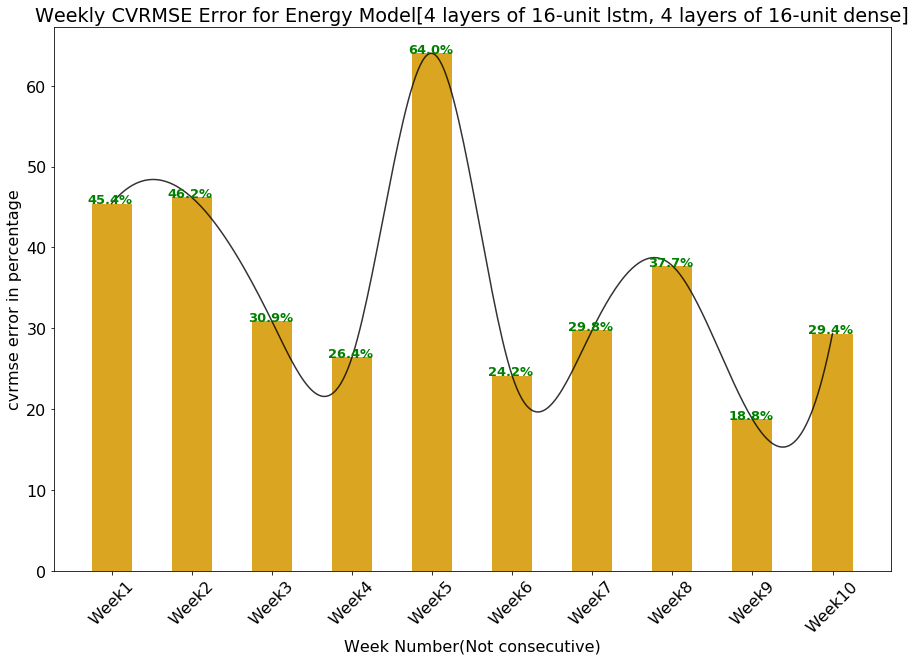

In [16]:
# Open a file
fo = open(path+"5min Results_File.txt", "r")
print ("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Week No:{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train':{'rmse': [], 'cvrmse' : [], 'mae' : []},
    'Test':{'rmse': [], 'cvrmse' : [], 'mae' : []}
}
for line in lines:
    p = parse.parse(parse_format,line)
    stats[p[2]]['rmse'].append(float(p[3]))
    stats[p[4]]['cvrmse'].append(float(p[5]))
    stats[p[6]]['mae'].append(float(p[7]))
          
fo.close()

# from dataprocess import plotutils as pu
plot_args = dict(
    bars = stats['Train']['cvrmse'],
    color = 'goldenrod',
    bar_label = 'cvrmse',
    saveloc = path,
    smoothcurve = True,
    bar_annotate = True,
    saveplot = True,
    xlabel = 'Week Number(Not consecutive)',
    ylabel = 'cvrmse error in percentage',
    title = 'Weekly CVRMSE Error for Energy Model[{} layers of {}-unit lstm, {} layers of {}-unit dense]'.format(config['lstm_no_layers'],config['lstm_hidden_units'], config['dense_no_layers'],config['dense_hidden_units']),
    xticktype = 'Week'
)
pu.single_bar_plot(
    **plot_args
)

In [ ]:
model.show_model()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '../results/lstmtrain/loginfo/' --port 8200

In [ ]:
dp.dataframeplot(dflist[2], lazy=False, style='-', legend=True)